In [7]:
#Student A: S2045321
#Student B: S2121327

# This is the code for the ASR course project.
import glob
import os
import sys
import math
import time
import wer
import observation_model
import openfst_python as fst


# For constructing WFST
def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.
    @param lex_file: a lexicon.txt file
    @return: a dictionary mapping words to list of phones
    """
    lex = {}  # lexcion dictionary
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()
            lex[line[0]] = line[1:]
    return lex


def generate_symbol_tables(lexicon, n=3):
    """
    Return word, phone and state symbol tables based on a lexicon dictionary
    @param lexicon: a lexicon dictionary created from the parse_lexicon() function
    @param n: number of states for each phone HMM
    @return: word_table (fst.SymbolTable): table of words
    @return: phone_table (fst.SymbolTable): table of phones
    @return: state_table (fst.SymbolTable): table of HMM phone-state IDs
    """
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    
    # add empty <eps> symbol to all tables
    state_table.add_symbol('<eps>')
    phone_table.add_symbol('<eps>')
    word_table.add_symbol('<eps>')
    
    for word, phones in lexicon.items():
       
        word_table.add_symbol(word)
        
        for p in phones: # for each phone
            
            phone_table.add_symbol(p)
            for i in range(1, n+1):  # state 1 to n
                state_table.add_symbol('{}_{}'.format(p, i))
            
    return word_table, phone_table, state_table


def generate_phone_wfst(f, start_state, phone, n, word=None):
    """
    Generate a WFST representating an n-state left-to-right phone HMM
    @param f: an existing FST
    @param start_state: an existing start state
    @param phone: a phone label
    @param n: nunber of state for each phone HMM
    @param end: the corresponding word
    @return: the final state of the WFST
    """
    
    current_state = start_state
    
    for i in range(1, n+1):
        
        in_label = state_table.find('{}_{}'.format(phone, i))
        
        # self-transition
        sl_weight = fst.Weight('log', -math.log(0.1))  # weight for self-transition
        f.add_arc(current_state, fst.Arc(in_label, 0, sl_weight, current_state))
        
        # transition to next state      
        # we want to output the phone label on the final state
        # note: if outputting words instead this code should be modified
        
#         if i == n:
#             out_label = phone_table.find(phone)
#         else:
#             out_label = 0   # output empty <eps> label          
        out_label = 0
        if word is not None and i==n:
            out_label = word_table.find(word)
        next_state = f.add_state()
        next_weight = fst.Weight('log', -math.log(0.9)) # weight to next state
        f.add_arc(current_state, fst.Arc(in_label, out_label, next_weight, next_state))    
       
        current_state = next_state
        
    return current_state


def generate_baseline_wfst(n=3):
    """
    Generate a HMM to recognise any single word sequence for words in the lexicon
    @param n (int): states per phone HMM
    @return: the WFST built
    """
    f = fst.Fst('log')
    start_state = f.add_state()
    f.set_start(start_state)
    
    for word, phones in lex.items():
        current_state = f.add_state()
        start_weight = fst.Weight('log', -math.log(0.1))
        f.add_arc(start_state, fst.Arc(0, 0, start_weight, current_state))
        
        for phone in phones[:-1]: 
            current_state = generate_phone_wfst(f, current_state, phone, n)
        current_state = generate_phone_wfst(f, current_state, phones[-1], n, word)
        
        final_weight = fst.Weight('log', -math.log(1))
        output_word = word_table.find(word)
#         next_state = f.add_state()
#         f.add_arc(current_state, fst.Arc(0, output_word, final_weight, next_state))
#         f.set_final(next_state)
#         f.add_arc(next_state, fst.Arc(0, 0, final_weight, start_state))
        f.set_final(current_state)
        f.add_arc(current_state, fst.Arc(0, 0, final_weight, start_state))
        
    return f


# Example Decoder from the labs.
class MyViterbiDecoder:
    
    NLL_ZERO = 1e10  # A constant representing -log(0)
    
    def __init__(self, f, audio_file_name):
        """
        Set up a decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()

        
    def initialise_decoding(self):
        """
        Set up the values for V_j(0) (as negative log-likelihoods)       
        """
        
        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j (best path)
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        self.V[0][self.f.start()] = 0.0  # set WFST start state a probability of 1.0  (-log(1) = 0)     
        self.traverse_epsilon_arcs(0)  # for epsilon-transitions (non-emitting states)  
        
        
    def traverse_epsilon_arcs(self, t):
        """
        Traverse arcs with <eps> on the input at time t
        These correspond to transitions that don't emit an observation (non-emitting states)        
        """
        num_computations = 0  # number of epsilon forward step 
        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        num_computations += 1  # one computation detected (we don't count the next computation)
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)
        return num_computations

    
    def forward_step(self, t):
        num_computations = 0  # number of forward step  
        for i in self.f.states():
            
            if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        num_computations += 1  # one computation detected
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []
        return num_computations
                            
    
    def finalise_decoding(self):
        """ this incorporates the probability of terminating at each state
        """
        
        for state in self.f.states():
            final_weight = float(self.f.final(state))
            if self.V[-1][state] != self.NLL_ZERO:
                if final_weight == math.inf:
                    self.V[-1][state] = self.NLL_ZERO  # effectively says that we can't end in this state
                else:
                    self.V[-1][state] += final_weight
                    
        # get a list of all states where there was a path ending with non-zero probability
        finished = [x for x in self.V[-1] if x < self.NLL_ZERO]
        if not finished:  # if empty
            print("No path got to the end of the observations.")       
        
    def decode(self):
        self.initialise_decoding()
        t = 1
        num_forwards = 0  # measures number of forward steps during decoding
        num_eps_forwards = 0  # measure number of non-emitting forward steps during decoding
        while t <= self.om.observation_length():
            num_forwards += self.forward_step(t)
            num_eps_forwards += self.traverse_epsilon_arcs(t)  # we think eps transition should also be recorded
            t += 1
        self.finalise_decoding()
        return num_forwards + num_eps_forwards  # return total number of forward computations
    
    def backtrace(self):
        
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state
        
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)
            best_out_sequence = self.W[t][j] + best_out_sequence  # can be made even more efficient

            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        # convert the best output sequence from FST integer labels into strings
        best_out_sequence = [self.f.output_symbols().find(label) for label in best_out_sequence]
        
        return (best_state_sequence, best_out_sequence)


# Utility functions
def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """

    transcription_file = os.path.splitext(wav_file)[0] + '.txt'

    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()

    return transcription

def average_WER(t_s, t_d, t_i, t_c):
    """
    Calculate average word error rate
    """
    return (t_s + t_d + t_i)/t_c


def average_WER_from_results(results_file):
    t_s = 0
    t_d = 0
    t_i = 0
    t_c = 0
    t_t_db = 0
    t_fc = 0
    t_wfst_s = 0
    t_wfst_a = 0
    recording_counts = 0
    with open(results_file, 'r') as f:
        for line in f:
            recording_counts += 1
            values = line.strip().split('\t')
            t_s += int(values[0])
            t_d += int(values[1])
            t_i += int(values[2])
            t_c += int(values[3])
            t_t_db += float(values[4])
            t_fc += int(values[5])
            t_wfst_s += int(values[6])
            t_wfst_a += int(values[7])
        print('Total S, D, I, N, Average-WER')
        print(t_s, t_d, t_i, t_c, average_WER(t_s, t_d, t_i, t_c))
        print("Average Time for Decoding + Backtracing: {}".format(round(t_db/recording_counts, 3)))  # decoding + backtracing time
        print("Average Decoding forward computations: {}".format(round(num_forward_computations/recording_counts, 3)))  # number of fw-computations during decoding
        print("Average WFST states: {}".format(round(wfst_states/recording_counts, 3)))
        print("Average WFST arcs: {}".format(round(wfst_arcs/recording_counts, 3)))

 

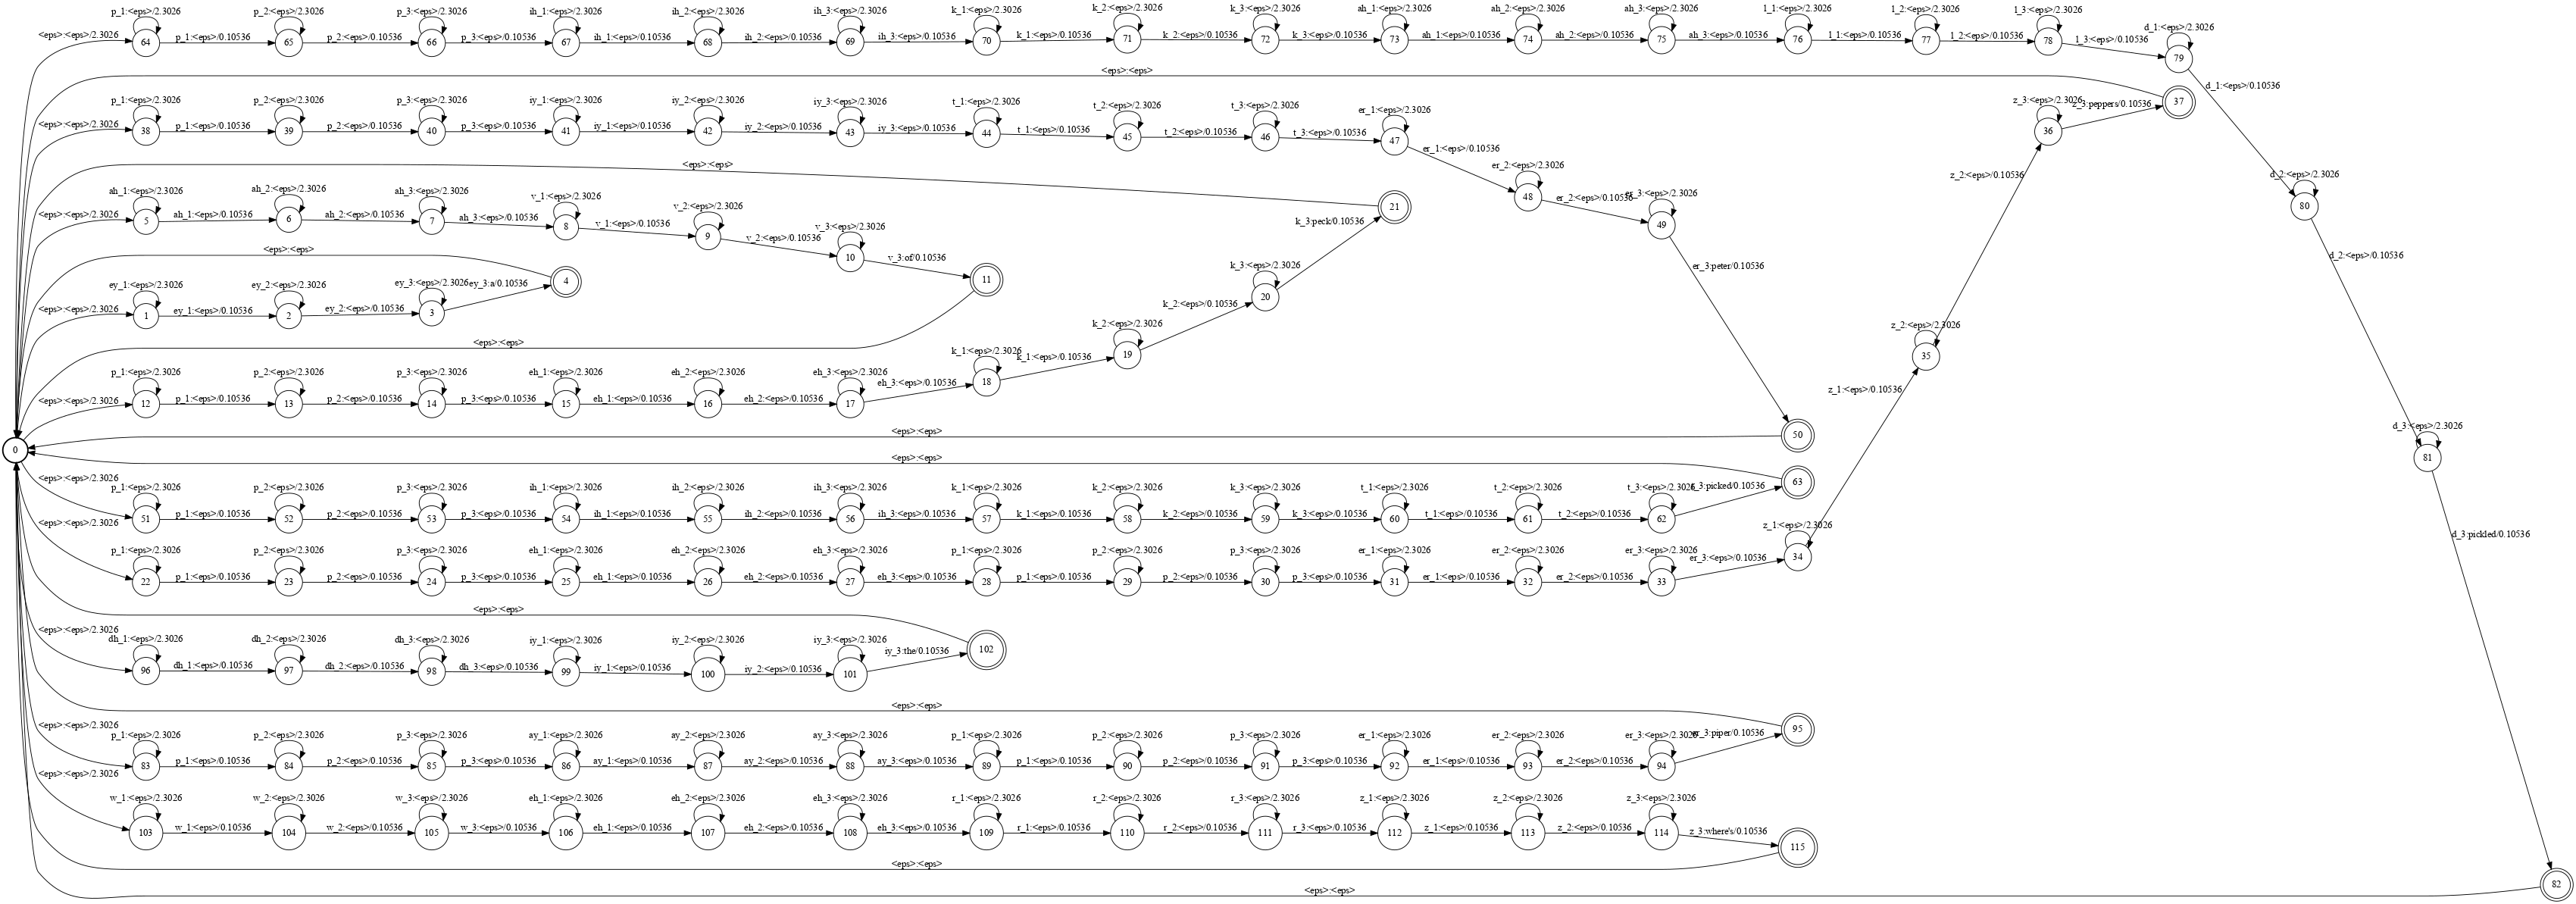

In [8]:
lex = parse_lexicon('lexicon.txt')  # create a lexicon dictionary from a lexicon text file
word_table, phone_table, state_table = generate_symbol_tables(lex)  # create tables for FST

# create a WFST that recognise any phone-based word sequence
f = generate_baseline_wfst(n=3)  
f.set_input_symbols(state_table)
f.set_output_symbols(word_table)

# for viewing the cut-off image
from subprocess import check_call
f.draw('tmp.dot', portrait=True)
check_call(['dot','-Tpng','-Gdpi=400','tmp.dot','-o','tmp.png'])
from IPython.display import Image
Image(filename='tmp.png')

In [9]:
# start recognition
print('START')
total_S = 0  # total Substitution
total_D = 0  # total Deletion
total_I = 0  # total Insertion
total_N = 0  # total words in reference transcription
avg_WER = 0  # average WER
out_results = 'exp_temp.txt'  # output-to file
#read_results = 'results_T1.txt'  # read-from file
#average_WER_from_results(read_results)  # show results from a results log file
#sys.exit(0)

with open(out_results, "a") as file:
    for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):  # audio data
        decoder = MyViterbiDecoder(f, wav_file)  # create decoder object
        # Decoding
        t_start = time.time()  # for measuring decoding time
        num_forward_computations = decoder.decode()  # decoding + recording the number of fw-computations
        
        # Backtracing
        (state_path, words) = decoder.backtrace()  # backtracing
        t_end = time.time() 
        t_db = round(t_end - t_start, 3)  # decoding + backtracing time
        
        # Evaluating
        transcription = read_transcription(wav_file)
        error_counts = wer.compute_alignment_errors(transcription, words)
        word_count = len(transcription.split())
        total_S += error_counts[0]
        total_D += error_counts[1]
        total_I += error_counts[2]
        total_N += len(transcription)
        wfst_states = len(state_path)
        wfst_arcs = wfst_states - 1
        
        # Taking evaluation log
        file.write(str(error_counts[0]) + '\t' + 
                   str(error_counts[1]) + '\t' + 
                   str(error_counts[2]) + '\t' + 
                   str(word_count) + '\t' +
                   str(t_db) + '\t' +
                   str(num_forward_computations) + '\t' +
                   str(wfst_states) + '\t' +
                   str(wfst_arcs) + '\t' +
                   str(wav_file)[-9:] + '\n')
        
        # Print iteratoin info
        print(words)
        print(error_counts, word_count)  #  error counts for a single wav file
        print("Time for Decoding + Backtracing: {}".format(t_db))  # decoding + backtracing time
        print("Decoding forward computations: {}".format(num_forward_computations))  # number of fw-computations during decoding
        print("WFST states: {}".format(wfst_states))
        print("WFST arcs: {}".format(wfst_arcs))

    average_WER_from_results(out_results)  # show results from a results log file


START
Total S, D, I, N, Average-WER
21 2 61 110 0.7636363636363637
Average Time for Decoding + Backtracing: 0.165
Average Decoding forward computations: 6150.667
Average WFST states: 28.4
Average WFST arcs: 28.333


SystemExit: 0

/afs/inf.ed.ac.uk/user/s21/s2121327/.conda/envs/asr_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
